# TransitVision: Transit Data Analysis and Prediction

This notebook demonstrates the key functionality of the TransitVision project using standalone code without requiring package installation.

## Setup and Configuration

First, let's import the necessary modules and set up the environment.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

# Set up visualization
try:
    # For newer versions of seaborn
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        # For older versions of seaborn
        plt.style.use('seaborn-whitegrid')
    except:
        # Fallback to basic grid
        plt.grid(True)

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("Environment setup complete!")

Environment setup complete!


## Generate Sample Data

For this demonstration, we'll generate synthetic transit data to work with.

In [6]:
def generate_transit_data(n_days=90, n_routes=5, n_stops_per_route=10, seed=42):
    """Generate synthetic transit data for demonstration."""
    np.random.seed(seed)
    
    # Generate dates
    start_date = pd.Timestamp('2023-01-01')
    dates = [start_date + pd.Timedelta(days=i) for i in range(n_days)]
    
    # Generate routes and stops
    routes = [f"Route_{i}" for i in range(1, n_routes + 1)]
    stops = [f"Stop_{i}" for i in range(1, n_stops_per_route + 1)]
    
    # Create base dataframe structure
    data = []
    
    for date in dates:
        # Weekend modifier for ridership
        is_weekend = date.dayofweek >= 5
        weekend_factor = 0.7 if is_weekend else 1.0
        
        # Monthly seasonality (higher in summer)
        month = date.month
        monthly_factor = 1.0 + 0.2 * np.sin((month - 1) * np.pi / 6)
        
        # Weather effect (random daily factor)
        weather_factor = np.random.uniform(0.8, 1.2)
        
        # Remote work percentage (gradually increasing over time)
        day_index = (date - start_date).days
        remote_work_pct = 20 + 10 * (day_index / n_days)
        
        for route in routes:
            # Route-specific factors
            route_idx = int(route.split('_')[1])
            route_factor = 0.8 + 0.1 * route_idx
            
            for stop in stops:
                # Stop-specific factors
                stop_idx = int(stop.split('_')[1])
                stop_factor = 0.9 + 0.02 * stop_idx
                
                # Calculate base ridership
                base_ridership = 100 * route_factor * stop_factor
                
                # Apply modifiers
                ridership = base_ridership * weekend_factor * monthly_factor * weather_factor
                
                # Apply remote work effect (more impact on commuter routes)
                remote_work_impact = 1.0 - (0.01 * remote_work_pct * route_factor)
                ridership = ridership * remote_work_impact
                
                # Add some random noise
                ridership = max(0, int(ridership * np.random.normal(1, 0.1)))
                
                # Generate capacity (somewhat correlated with ridership)
                capacity = int(max(ridership * 1.5, 150) * np.random.uniform(0.9, 1.1))
                
                # Generate delay (correlated with ridership/capacity ratio)
                utilization = ridership / capacity
                delay_base = 2 * utilization * np.random.exponential(1)
                delay = round(max(0, delay_base), 1)
                
                # Create data point
                data.append({
                    'service_date': date,
                    'route_id': route,
                    'stop_id': stop,
                    'ridership': ridership,
                    'capacity': capacity,
                    'delay': delay,
                    'temperature': round(20 + 10 * np.sin((date.dayofweek - 1) * np.pi / 7) + np.random.normal(0, 3), 1),
                    'precipitation': max(0, round(np.random.exponential(0.5), 2)),
                    'is_holiday': date.dayofweek >= 5 or np.random.random() < 0.05,
                    'remote_work_percent': round(remote_work_pct, 1),
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Add time features
    df['service_month'] = df['service_date'].dt.month
    df['service_day'] = df['service_date'].dt.day
    df['service_dayofweek'] = df['service_date'].dt.dayofweek
    df['is_weekend'] = df['service_dayofweek'] >= 5
    
    return df

def generate_feedback_data(transit_data, n_feedback=500, seed=42):
    """Generate synthetic feedback data based on transit data."""
    np.random.seed(seed)
    
    # Sample from transit data to get realistic dates and routes
    sampled_data = transit_data.sample(n=n_feedback, random_state=seed)
    
    # Positive feedback templates
    positive_templates = [
        "The {route} was on time and clean. Very satisfied with the service.",
        "Driver was friendly and helpful. {route} was punctual as always.",
        "Great experience on {route} today. Comfortable ride and efficient service.",
        "Love the new schedule for {route}, makes my commute much easier.",
        "The bus was clean and not crowded. Very pleasant ride on {route}.",
        "Excellent service on {route} this morning. Right on schedule!",
        "The {route} driver was very professional and courteous.",
        "I appreciate the reliability of {route}. Always a good experience."
    ]
    
    # Negative feedback templates
    negative_templates = [
        "The {route} was late again. Very frustrating for daily commuters.",
        "Bus was overcrowded and uncomfortable. {route} needs more frequent service.",
        "Driver was rude and unhelpful. Poor experience on {route} today.",
        "The {route} was dirty and had a bad smell. Please improve cleaning.",
        "Disappointed with {route} service. Too many delays and no communication.",
        "The air conditioning wasn't working on {route}. Terrible experience in this heat.",
        "Why is {route} always late? Need better schedule adherence.",
        "The {route} bus broke down mid-journey. Needs better maintenance."
    ]
    
    # Neutral feedback templates
    neutral_templates = [
        "Average experience on {route}. Nothing special to report.",
        "The {route} was slightly delayed but overall okay.",
        "Regular service on {route} today. No issues to mention.",
        "Standard experience on {route}. Could use some minor improvements.",
        "The {route} was adequate for my needs today.",
        "Typical journey on {route}. Neither good nor bad.",
        "The {route} was moderately crowded but manageable.",
        "Satisfactory service on {route}, though there's room for improvement."
    ]
    
    # Generate feedback
    data = []
    
    for _, row in sampled_data.iterrows():
        # Determine sentiment based on delay and ridership/capacity ratio
        delay = row['delay']
        utilization = row['ridership'] / row['capacity']
        
        # Calculate base sentiment score (-1 to 1)
        sentiment_score = 0.5 - (delay / 15) - (utilization - 0.5)
        sentiment_score += np.random.normal(0, 0.3)  # Add noise
        
        # Determine sentiment category
        if sentiment_score > 0.3:
            sentiment = "positive"
            rating = np.random.choice([4, 5], p=[0.3, 0.7])
            template = np.random.choice(positive_templates)
        elif sentiment_score < -0.3:
            sentiment = "negative"
            rating = np.random.choice([1, 2], p=[0.7, 0.3])
            template = np.random.choice(negative_templates)
        else:
            sentiment = "neutral"
            rating = np.random.choice([3, 4], p=[0.7, 0.3])
            template = np.random.choice(neutral_templates)
        
        # Format feedback text
        feedback_text = template.format(route=row['route_id'])
        
        # Add some typos or variations (10% chance per feedback)
        if np.random.random() < 0.1:
            words = feedback_text.split()
            if len(words) > 3:
                word_idx = np.random.randint(0, len(words))
                if len(words[word_idx]) > 3:
                    char_idx = np.random.randint(1, len(words[word_idx]) - 1)
                    word_list = list(words[word_idx])
                    word_list[char_idx] = np.random.choice(list('abcdefghijklmnopqrstuvwxyz'))
                    words[word_idx] = ''.join(word_list)
                    feedback_text = ' '.join(words)
        
        # Create feedback entry
        data.append({
            'feedback_text': feedback_text,
            'feedback_date': row['service_date'],
            'route_id': row['route_id'],
            'stop_id': row['stop_id'],
            'rating': rating,
            'sentiment': sentiment
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    return df

# Generate the datasets
transit_data = generate_transit_data()
feedback_data = generate_feedback_data(transit_data)

# Display sample data
print(f"Transit data shape: {transit_data.shape}")
print(f"Feedback data shape: {feedback_data.shape}")

transit_data.head()

Transit data shape: (4500, 14)
Feedback data shape: (500, 6)


,service_date,route_id,stop_id,ridership,capacity,delay,temperature,precipitation,is_holiday,remote_work_percent,service_month,service_day,service_dayofweek,is_weekend
0,2023-01-01,Route_1,Stop_1,40,139,0.0,28.8,1.01,True,20.0,1,1,6,True
1,2023-01-01,Route_1,Stop_2,53,135,2.8,30.1,0.89,True,20.0,1,1,6,True
2,2023-01-01,Route_1,Stop_3,44,140,0.2,26.2,0.37,True,20.0,1,1,6,True
3,2023-01-01,Route_1,Stop_4,39,153,0.1,26.1,0.17,True,20.0,1,1,6,True
4,2023-01-01,Route_1,Stop_5,45,158,0.1,21.4,0.36,True,20.0,1,1,6,True


## Data Processing

Now let's implement our own transit data processing functions.

In [8]:
def process_transit_data(data):
    """Process transit data for analysis."""
    df = data.copy()
    
    # Handle missing values in numerical columns
    numerical_columns = ["ridership", "capacity", "delay", "temperature", "precipitation"]
    for col in numerical_columns:
        if col in df.columns and df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())
    
    # Handle categorical columns
    categorical_columns = ["route_id", "stop_id"]
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    # Convert date columns
    date_columns = ["service_date"]
    for col in date_columns:
        if col in df.columns and not pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = pd.to_datetime(df[col])
    
    # Handle outliers in numerical columns
    for col in numerical_columns:
        if col in df.columns:
            # Calculate z-scores
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            
            # Identify outliers (z-score > 3)
            outliers = z_scores > 3
            
            # Replace outliers with median
            if outliers.sum() > 0:
                df.loc[outliers, col] = df[col].median()
                print(f"Replaced {outliers.sum()} outliers in {col}")
    
    # Add derived features
    df['utilization_rate'] = df['ridership'] / df['capacity']
    
    # Extract more time features from service_date
    if 'service_date' in df.columns:
        # Week of year
        df['service_week'] = df['service_date'].dt.isocalendar().week
        # Quarter
        df['service_quarter'] = df['service_date'].dt.quarter
    
    print(f"Processed transit data: {df.shape}")
    return df

def process_feedback_data(data):
    """Process feedback data for analysis."""
    df = data.copy()
    
    # Clean text
    df['clean_text'] = df['feedback_text'].str.lower()
    
    # Extract text features
    df['text_length'] = df['feedback_text'].str.len()
    df['word_count'] = df['feedback_text'].str.split().str.len()
    
    # Convert date
    if 'feedback_date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['feedback_date']):
        df['feedback_date'] = pd.to_datetime(df['feedback_date'])
    
    # Filter out very short feedback
    df = df[df['word_count'] >= 3]
    
    print(f"Processed feedback data: {df.shape}")
    return df

# Process the data
processed_transit_data = process_transit_data(transit_data)
processed_feedback_data = process_feedback_data(feedback_data)

# Display the processed data
processed_transit_data.head()

Replaced 4 outliers in ridership
Replaced 70 outliers in capacity
Replaced 92 outliers in delay
Replaced 2 outliers in temperature
Replaced 83 outliers in precipitation
Processed transit data: (4500, 17)
Processed feedback data: (500, 9)


,service_date,route_id,stop_id,ridership,capacity,delay,temperature,precipitation,is_holiday,remote_work_percent,service_month,service_day,service_dayofweek,is_weekend,utilization_rate,service_week,service_quarter
0,2023-01-01,Route_1,Stop_1,40,139,0.0,28.8,1.01,True,20.0,1,1,6,True,0.287770,52,1
1,2023-01-01,Route_1,Stop_2,53,135,2.8,30.1,0.89,True,20.0,1,1,6,True,0.392593,52,1
2,2023-01-01,Route_1,Stop_3,44,140,0.2,26.2,0.37,True,20.0,1,1,6,True,0.314286,52,1
3,2023-01-01,Route_1,Stop_4,39,153,0.1,26.1,0.17,True,20.0,1,1,6,True,0.254902,52,1
4,2023-01-01,Route_1,Stop_5,45,158,0.1,21.4,0.36,True,20.0,1,1,6,True,0.284810,52,1


## Transit Data Analysis

Now let's implement analysis functions for the transit data.

Top 5 rows of ridership patterns:
  service_date route_id  ridership_sum  ridership_mean  ridership_median  \
0   2023-01-01  Route_1            469            46.9              46.5   
1   2023-01-01  Route_2            526            52.6              53.0   
2   2023-01-01  Route_3            559            55.9              55.5   
3   2023-01-01  Route_4            597            59.7              58.0   
4   2023-01-01  Route_5            657            65.7              65.0   

   ridership_count  capacity_sum  capacity_mean  
0               10          1438          143.8  
1               10          1492          149.2  
2               10          1430          143.0  
3               10          1477          147.7  
4               10          1513          151.3  


/var/folders/p9/0vm798q10w1gg13f4_xqy_s80000gn/T/ipykernel_8593/1975249065.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(time_grouper + ['route_id']).agg({


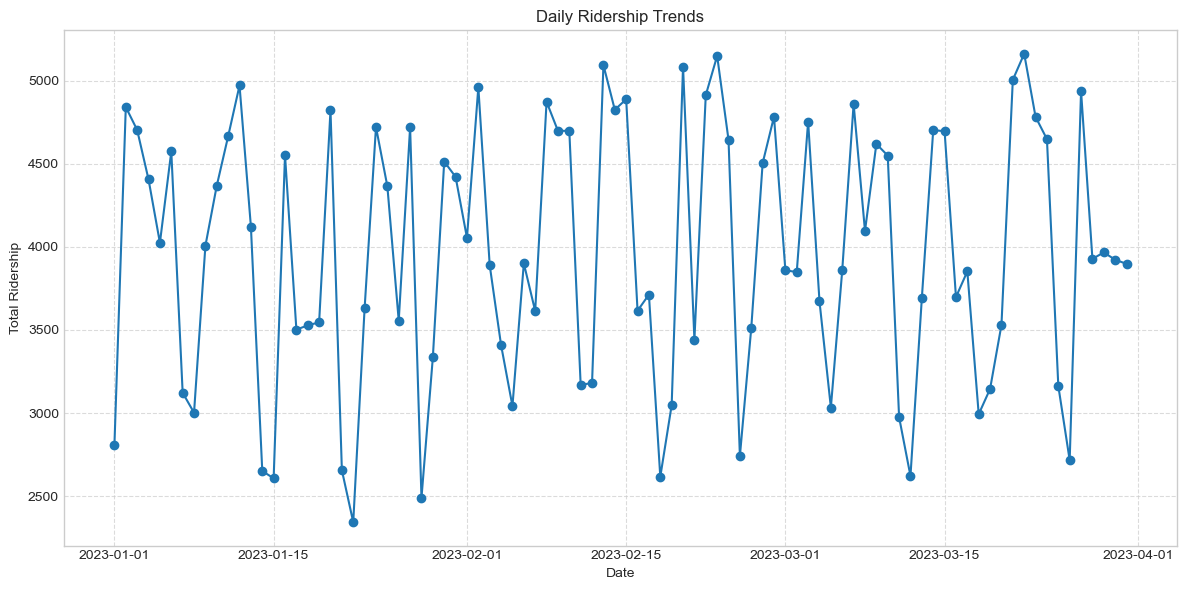

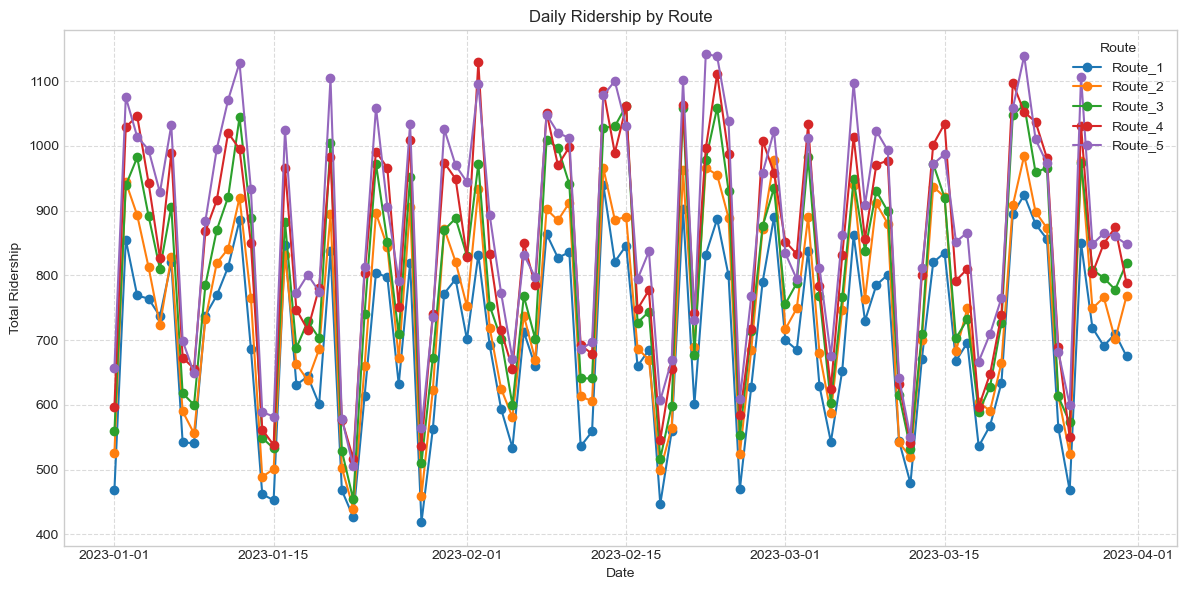

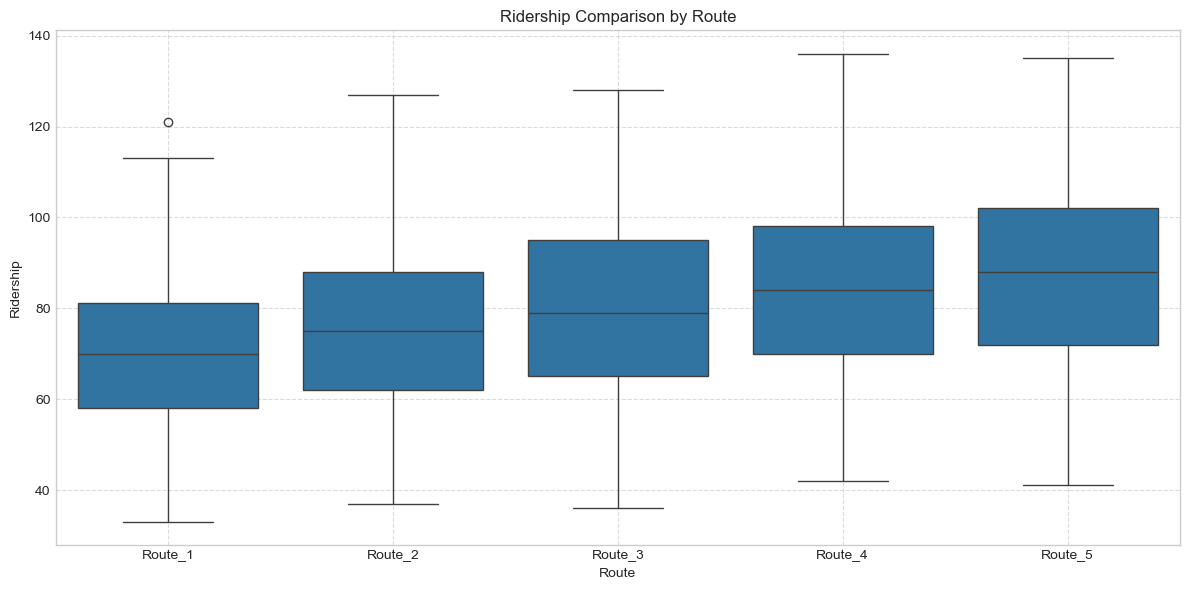

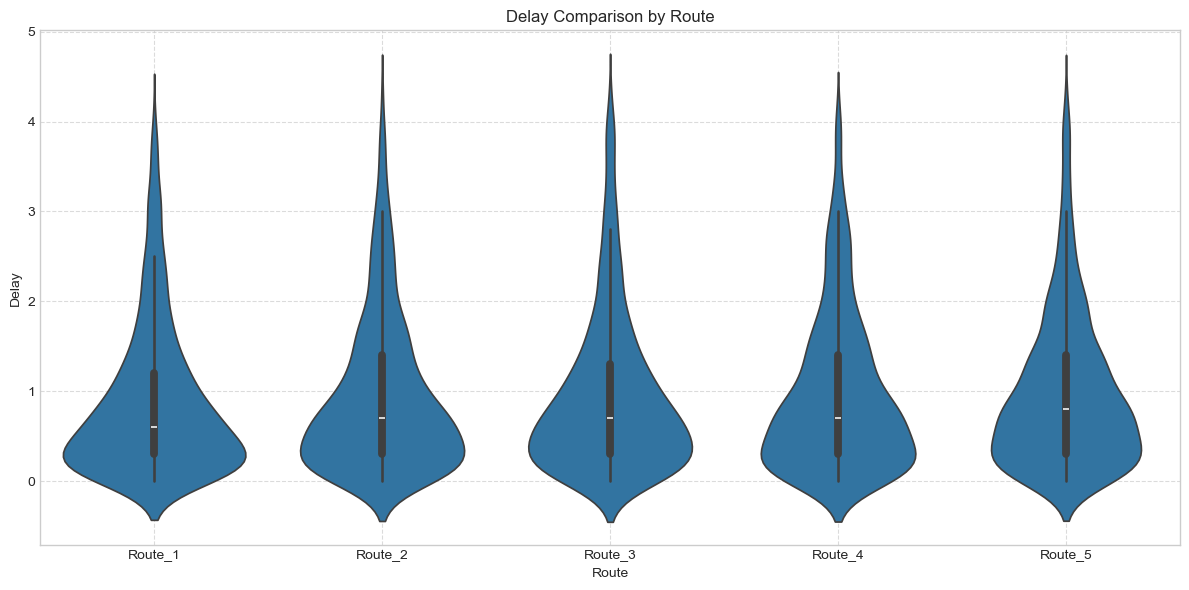

In [10]:
def analyze_ridership_patterns(data, time_grouping="daily"):
    """Analyze ridership patterns over time."""
    df = data.copy()
    
    # Determine groupby columns based on time_grouping
    if time_grouping == "daily":
        time_grouper = ['service_date']
    elif time_grouping == "weekly":
        time_grouper = ['service_week']
    elif time_grouping == "monthly":
        time_grouper = ['service_month']
    else:
        raise ValueError(f"Unsupported time grouping: {time_grouping}")
    
    # Group by time and route to calculate ridership metrics
    result = df.groupby(time_grouper + ['route_id']).agg({
        'ridership': ['sum', 'mean', 'median', 'count'],
        'capacity': ['sum', 'mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    result.columns = ['_'.join(col).strip('_') for col in result.columns.values]
    
    return result

def plot_ridership_trends(data, time_grouping="daily"):
    """Plot ridership trends over time."""
    df = data.copy()
    
    if time_grouping == "daily":
        # Group by date and calculate total ridership
        ridership_by_date = df.groupby('service_date')['ridership'].sum().reset_index()
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(ridership_by_date['service_date'], ridership_by_date['ridership'], marker='o')
        plt.title('Daily Ridership Trends')
        plt.xlabel('Date')
        plt.ylabel('Total Ridership')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Plot by route
        plt.figure(figsize=(12, 6))
        for route in df['route_id'].unique():
            route_data = df[df['route_id'] == route]
            ridership_by_date = route_data.groupby('service_date')['ridership'].sum().reset_index()
            plt.plot(ridership_by_date['service_date'], ridership_by_date['ridership'], 
                     marker='o', label=route)
        
        plt.title('Daily Ridership by Route')
        plt.xlabel('Date')
        plt.ylabel('Total Ridership')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Route')
        plt.tight_layout()
        plt.show()

def plot_performance_comparison(data, metric="ridership", plot_type="boxplot"):
    """Plot transit performance comparison."""
    df = data.copy()
    
    plt.figure(figsize=(12, 6))
    
    if plot_type == "boxplot":
        sns.boxplot(x='route_id', y=metric, data=df)
    elif plot_type == "violin":
        sns.violinplot(x='route_id', y=metric, data=df)
    elif plot_type == "bar":
        route_metric = df.groupby('route_id')[metric].mean().reset_index()
        sns.barplot(x='route_id', y=metric, data=route_metric)
    
    plt.title(f'{metric.capitalize()} Comparison by Route')
    plt.xlabel('Route')
    plt.ylabel(metric.capitalize())
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Analyze ridership patterns
ridership_patterns = analyze_ridership_patterns(processed_transit_data, time_grouping="daily")
print("Top 5 rows of ridership patterns:")
print(ridership_patterns.head())

# Plot ridership trends
plot_ridership_trends(processed_transit_data, time_grouping="daily")

# Plot performance comparisons
plot_performance_comparison(processed_transit_data, metric="ridership", plot_type="boxplot")
plot_performance_comparison(processed_transit_data, metric="delay", plot_type="violin")

## Sentiment Analysis

Let's analyze the sentiment in the rider feedback.

Sentiment distribution by route:
sentiment_category  negative    neutral   positive
route_id                                          
Route_1             1.020408  17.346939  81.632653
Route_2             2.127660  25.531915  72.340426
Route_3             2.631579  28.070175  69.298246
Route_4             5.681818  26.136364  68.181818
Route_5             2.830189  20.754717  76.415094


<Figure size 1200x600 with 0 Axes>

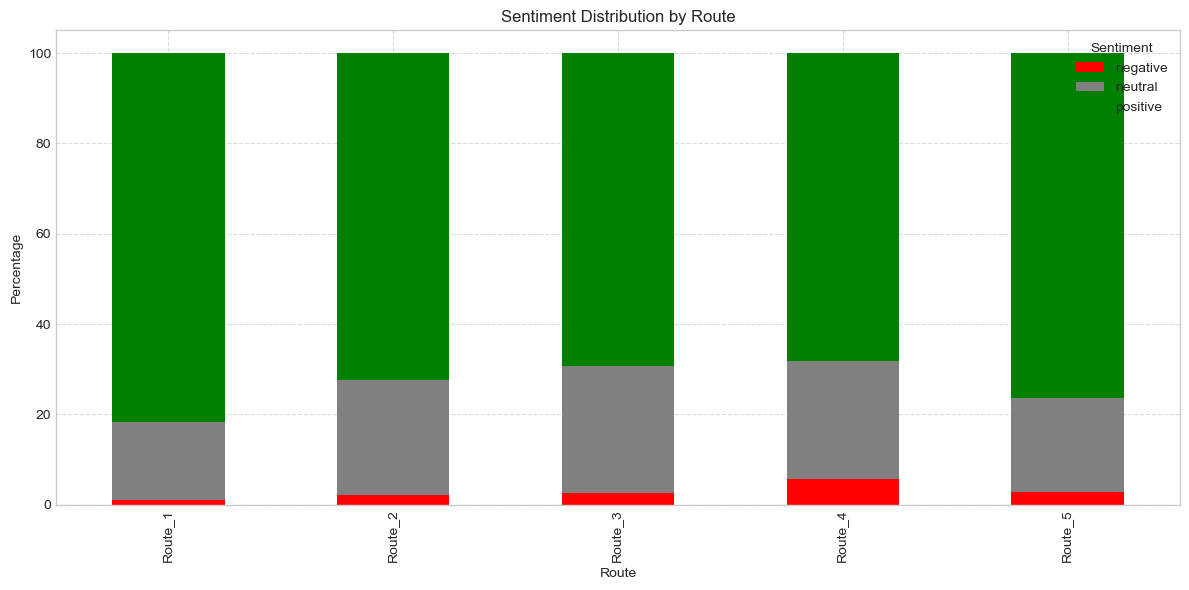


Common topics in positive feedback:
  service: 120
  always: 90
  experience: 85
  clean: 81
  driver: 79

Common topics in negative feedback:
  late: 5
  service: 4
  better: 4
  too: 3
  many: 3


In [12]:
def analyze_sentiment(feedback_data):
    """Basic sentiment analysis based on ratings."""
    df = feedback_data.copy()
    
    # Map ratings to sentiment categories
    df['sentiment_category'] = df['rating'].apply(
        lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
    )
    
    # Count sentiment by route
    sentiment_by_route = df.groupby(['route_id', 'sentiment_category']).size().unstack(fill_value=0)
    
    # Calculate percentages
    sentiment_pct = sentiment_by_route.div(sentiment_by_route.sum(axis=1), axis=0) * 100
    
    return sentiment_pct

def plot_sentiment_distribution(sentiment_data):
    """Plot sentiment distribution."""
    # Plot sentiment distribution
    plt.figure(figsize=(12, 6))
    sentiment_data.plot(kind='bar', stacked=True, 
                        color=['red', 'gray', 'green'])
    plt.title('Sentiment Distribution by Route')
    plt.xlabel('Route')
    plt.ylabel('Percentage')
    plt.legend(title='Sentiment')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def extract_topics(feedback_data, sentiment, n_topics=5):
    """Extract common topics from feedback of a specific sentiment."""
    df = feedback_data.copy()
    
    # Filter by sentiment
    sentiment_data = df[df['sentiment'] == sentiment]
    
    # Simple word frequency analysis
    from collections import Counter
    import re
    
    # Common stopwords
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'was', 'is', 'are', 'be', 'been', 
                 'being', 'have', 'has', 'had', 'to', 'for', 'with', 'on', 'at', 'by',
                 'in', 'of', 'very', 'route', 'bus', 'transit'}
    
    # Combine all text
    all_text = ' '.join(sentiment_data['feedback_text'].str.lower())
    
    # Tokenize and count
    words = re.findall(r'\b[a-z]{3,}\b', all_text)  # Only keep words with at least 3 letters
    words = [word for word in words if word not in stopwords]
    
    # Get most common words
    word_counts = Counter(words)
    top_topics = word_counts.most_common(n_topics)
    
    return top_topics

# Analyze sentiment
sentiment_results = analyze_sentiment(processed_feedback_data)
print("Sentiment distribution by route:")
print(sentiment_results)

# Plot sentiment distribution
plot_sentiment_distribution(sentiment_results)

# Extract topics for each sentiment
print("\nCommon topics in positive feedback:")
positive_topics = extract_topics(processed_feedback_data, 'positive')
for topic, count in positive_topics:
    print(f"  {topic}: {count}")

print("\nCommon topics in negative feedback:")
negative_topics = extract_topics(processed_feedback_data, 'negative')
for topic, count in negative_topics:
    print(f"  {topic}: {count}")

## Ridership Prediction

Now let's build a model to predict transit ridership.

Training data shape: (3600, 23)
Testing data shape: (900, 23)

Building prediction model...

Evaluating model performance...
RMSE: 10.41
MAE: 8.17
R²: 0.71


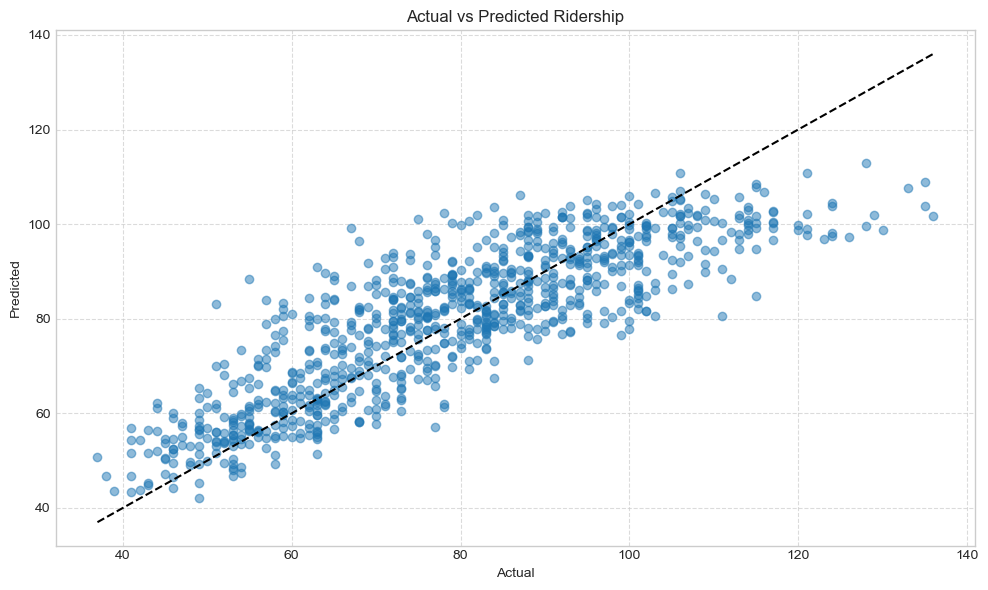

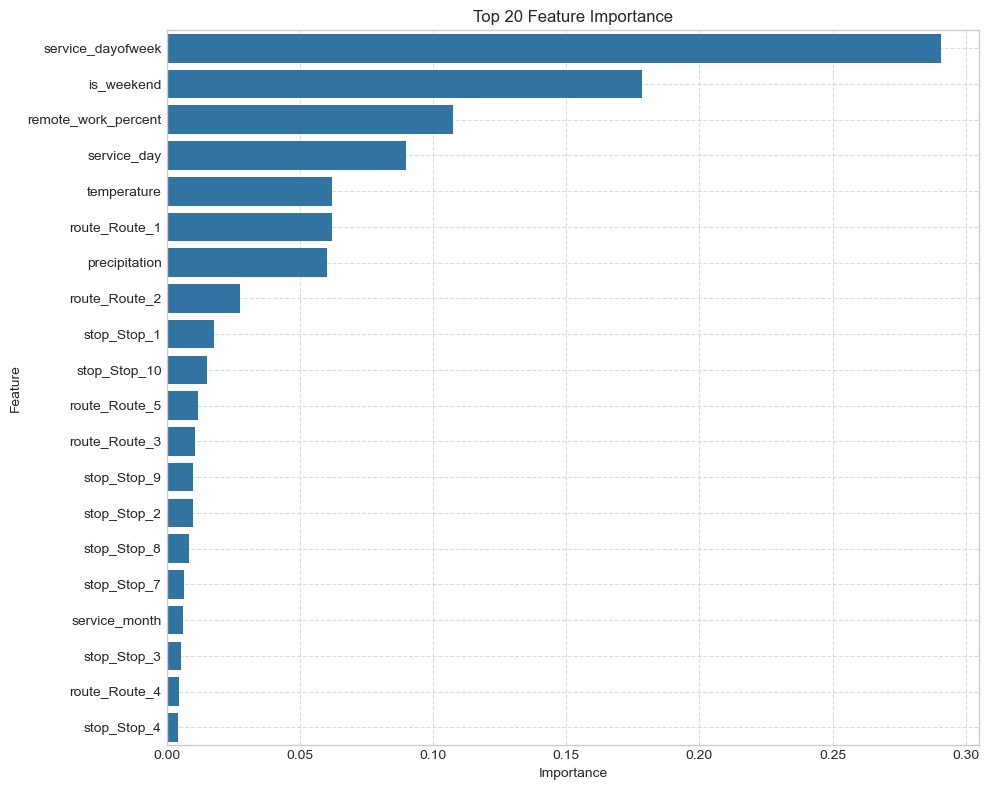

In [14]:
def build_prediction_model(X_train, y_train):
    """Build a simple random forest model for ridership prediction."""
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    
    # Create pipeline with scaling and random forest
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate the prediction model."""
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Ridership')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return y_pred

def get_feature_importance(model, feature_names):
    """Get feature importance from model."""
    # Extract feature importance from random forest
    importance = model.named_steps['rf'].feature_importances_
    
    # Create DataFrame with feature names and importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    return feature_importance

def plot_feature_importance(feature_importance, top_n=20):
    """Plot feature importance."""
    # Limit to top N features
    if len(feature_importance) > top_n:
        plot_data = feature_importance.head(top_n)
    else:
        plot_data = feature_importance
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=plot_data)
    plt.title(f'Top {top_n} Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Prepare data for modeling
from sklearn.model_selection import train_test_split

# Select features and target
features = [
    'service_month', 'service_day', 'service_dayofweek', 'is_weekend',
    'temperature', 'precipitation', 'is_holiday', 'remote_work_percent'
]

# Add route and stop dummy variables
route_dummies = pd.get_dummies(processed_transit_data['route_id'], prefix='route')
stop_dummies = pd.get_dummies(processed_transit_data['stop_id'], prefix='stop')

# Combine features
X = pd.concat([processed_transit_data[features], route_dummies, stop_dummies], axis=1)
y = processed_transit_data['ridership']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Build and evaluate model
print("\nBuilding prediction model...")
model = build_prediction_model(X_train, y_train)

print("\nEvaluating model performance...")
y_pred = evaluate_model(model, X_test, y_test)

# Get and plot feature importance
feature_importance = get_feature_importance(model, X.columns)
plot_feature_importance(feature_importance)

## Remote Work Impact Analysis

Let's analyze how remote work patterns affect transit ridership.

Remote work impact on ridership:
  remote_work_bracket  ridership_mean  ridership_median  ridership_std  \
0               0-10%             NaN               NaN            NaN   
1              10-20%       56.160000              55.0       9.287604   
2              20-30%       79.560674              79.0      19.163433   
3              30-40%             NaN               NaN            NaN   
4              40-50%             NaN               NaN            NaN   
5              50-60%             NaN               NaN            NaN   
6              60-70%             NaN               NaN            NaN   
7             70-100%             NaN               NaN            NaN   

   ridership_count  
0                0  
1               50  
2             4450  
3                0  
4                0  
5                0  
6                0  
7                0  


/var/folders/p9/0vm798q10w1gg13f4_xqy_s80000gn/T/ipykernel_8593/3819392091.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby('remote_work_bracket').agg({


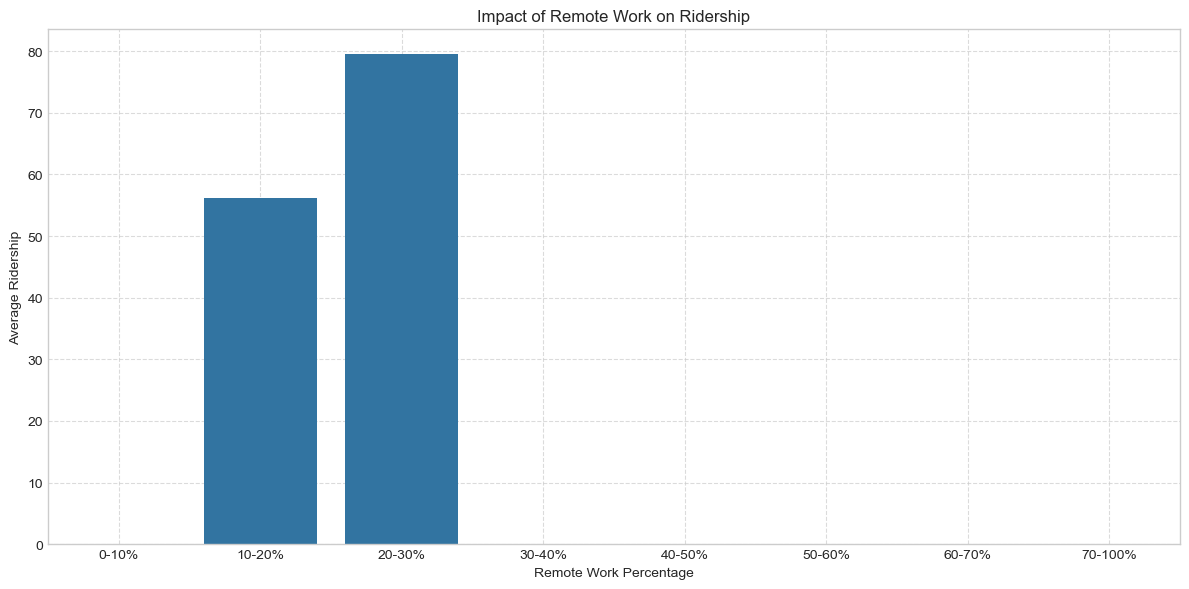

/var/folders/p9/0vm798q10w1gg13f4_xqy_s80000gn/T/ipykernel_8593/3819392091.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['remote_work_bracket', 'is_weekend'])['ridership'].mean().reset_index()


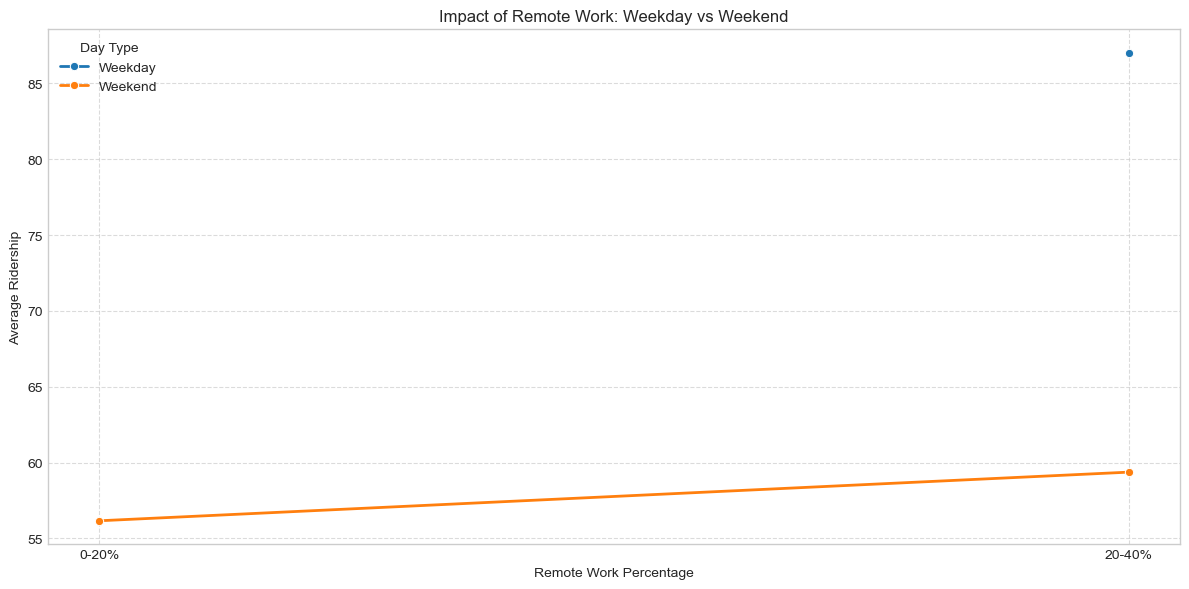

In [16]:
def analyze_remote_work_impact(data, route=None):
    """Analyze the impact of remote work on ridership."""
    df = data.copy()
    
    # Filter by route if specified
    if route is not None:
        df = df[df['route_id'] == route]
    
    # Group by remote work percentage brackets
    df['remote_work_bracket'] = pd.cut(
        df['remote_work_percent'], 
        bins=[0, 10, 20, 30, 40, 50, 60, 70, 100],
        labels=["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-100%"]
    )
    
    # Calculate average ridership by remote work bracket
    result = df.groupby('remote_work_bracket').agg({
        'ridership': ['mean', 'median', 'std', 'count']
    }).reset_index()
    
    # Flatten MultiIndex columns
    result.columns = ['_'.join(col).strip('_') for col in result.columns.values]
    
    return result

def plot_remote_work_impact(impact_data):
    """Plot impact of remote work on ridership."""
    plt.figure(figsize=(12, 6))
    
    # Bar plot of average ridership by remote work bracket
    sns.barplot(x='remote_work_bracket', y='ridership_mean', data=impact_data)
    
    plt.title('Impact of Remote Work on Ridership')
    plt.xlabel('Remote Work Percentage')
    plt.ylabel('Average Ridership')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def compare_weekday_weekend_impact(data):
    """Compare impact of remote work on weekdays vs weekends."""
    df = data.copy()
    
    # Group by remote work percentage brackets and weekday/weekend
    df['remote_work_bracket'] = pd.cut(
        df['remote_work_percent'], 
        bins=[0, 20, 40, 60, 80, 100],
        labels=["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]
    )
    
    # Calculate average ridership by remote work bracket and weekday/weekend
    result = df.groupby(['remote_work_bracket', 'is_weekend'])['ridership'].mean().reset_index()
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Convert boolean to string for better legend
    result['Day Type'] = result['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
    
    sns.lineplot(
        data=result,
        x='remote_work_bracket',
        y='ridership',
        hue='Day Type',
        marker='o',
        linewidth=2
    )
    
    plt.title('Impact of Remote Work: Weekday vs Weekend')
    plt.xlabel('Remote Work Percentage')
    plt.ylabel('Average Ridership')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Analyze remote work impact
remote_work_impact = analyze_remote_work_impact(processed_transit_data)
print("Remote work impact on ridership:")
print(remote_work_impact)

# Plot remote work impact
plot_remote_work_impact(remote_work_impact)

# Compare weekday/weekend impact
compare_weekday_weekend_impact(processed_transit_data)

## Conclusion

In this notebook, we've created a simple TransitVision system that demonstrates key capabilities:

1. Data processing for transit and feedback data
2. Transit data analysis and visualization
3. Sentiment analysis of rider feedback
4. Ridership prediction using machine learning
5. Remote work impact analysis

This standalone version works without requiring package installation, making it easy to run in any Jupyter environment.